# Personal Key Indicators of Heart Disease 
This Jupyter Notebook focus on cleaning and analyzing data from the 2020 annual CDC survey of 400k adults related to their health status. Data was obtained from kaggle at https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

The following steps were performed:
1. Loading data and cleaning
2. Splitting data into training/validation/test data
3. Feature importance:<br>
    3.1 Mutual information <br>
    3.2 Correlation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from scipy import stats

# 1. Loading data and cleaning

First data is loaded using `pandas` and stored into a `DataFrame`. Column names are normalized into lower case to ease the use. 

In [2]:
df = pd.read_csv('../datasets/heart_disease/heart_2020_cleaned.csv')
df.columns = df.columns.str.lower()

We can inspect our data using the `dtypes` variable.

In [3]:
df.dtypes

heartdisease         object
bmi                 float64
smoking              object
alcoholdrinking      object
stroke               object
physicalhealth      float64
mentalhealth        float64
diffwalking          object
sex                  object
agecategory          object
race                 object
diabetic             object
physicalactivity     object
genhealth            object
sleeptime           float64
asthma               object
kidneydisease        object
skincancer           object
dtype: object

Since we will be trying to **predict the risk of a heart disease**, our output will be the `heartdisease` column. A closer look at our data can be performed by using a histogram. Below it can be seen that our data distribution is not symmetrical, which means that instead of using precision as our metric for evaluation, we will be using the area under the curve `auc` as metric for evaluating our machine learning model.

In [4]:
df.heartdisease.value_counts(normalize=True)

No     0.914405
Yes    0.085595
Name: heartdisease, dtype: float64

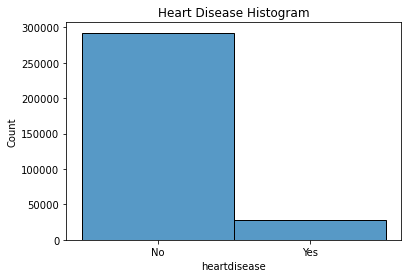

In [5]:
sns.histplot(df.heartdisease)
plt.title('Heart Disease Histogram')
plt.show()

We can separete our features in two groups: `numerical` and `categorical`. This separation will allow us to understand two key concepts in our data:
* Mutual information
* Correlation

We also remove from our features the `heartdisease` column.

In [6]:
numerical = list(df.dtypes[df.dtypes == 'float'].index.values)
numerical

['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']

In [7]:
categorical = list(df.dtypes[df.dtypes == 'object'].index.values)
categorical.remove('heartdisease')
categorical

['smoking',
 'alcoholdrinking',
 'stroke',
 'diffwalking',
 'sex',
 'agecategory',
 'race',
 'diabetic',
 'physicalactivity',
 'genhealth',
 'asthma',
 'kidneydisease',
 'skincancer']

In the case of `categorical` variables, it is desirable to normalize our data therefore we lower case our values.

In [8]:
for c in categorical:
    df[c] = df[c].str.lower()

In [9]:
df['heartdisease'] = df['heartdisease'].str.lower()

After all the preprocess we obtain the following `DataFrame`

In [10]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,319785,319786,319787,319788,319789,319790,319791,319792,319793,319794
heartdisease,no,no,no,no,no,yes,no,no,no,no,...,no,yes,no,no,no,yes,no,no,no,no
bmi,16.6,20.34,26.58,24.21,23.71,28.87,21.63,31.64,26.45,40.69,...,31.93,33.2,36.54,23.38,22.22,27.41,29.84,24.24,32.81,46.56
smoking,yes,no,yes,no,no,yes,no,yes,no,no,...,no,yes,no,no,no,yes,yes,no,no,no
alcoholdrinking,no,no,no,no,no,no,no,no,no,no,...,yes,no,no,no,no,no,no,no,no,no
stroke,no,yes,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
physicalhealth,3.0,0.0,20.0,0.0,28.0,6.0,15.0,5.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
mentalhealth,30.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
diffwalking,no,no,no,no,yes,yes,no,yes,no,yes,...,no,no,no,no,no,yes,no,no,no,no
sex,female,female,male,female,female,female,female,female,female,male,...,male,female,male,female,female,male,male,female,female,female
agecategory,55-59,80 or older,65-69,75-79,40-44,75-79,70-74,80 or older,80 or older,65-69,...,65-69,60-64,30-34,60-64,18-24,60-64,35-39,45-49,25-29,80 or older


# 2. Splitting data into training/validation/test data
For our machine learning model we will use a 80-20-20 splitting of training-validation-test data.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
#y_full_train = (df_full_train['heartdisease']=='yes').astype('int').values

y_train = (df_train['heartdisease']=='yes').astype('int').values
y_val = (df_val['heartdisease']=='yes').astype('int').values
y_test = (df_test['heartdisease']=='yes').astype('int').values

In [14]:
#df_full_train = df_full_train.drop(columns='heartdisease')
df_train = df_train.drop(columns='heartdisease')
df_val = df_val.drop(columns='heartdisease')
df_test = df_test.drop(columns='heartdisease')

In [15]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# 3. Feature importance
In this part we will explore the relationship between our `numerical` and `categorical` predictors against our output. This analysis will provide us with valuable information of what might trigger a heart disease.

## 3.1 Mutual information
Is used for categorical variables and quantifies the "amount of information" (in units such as shannons (bits), nats or hartleys) obtained about one random variable by observing the other random variable. The mutual information determines how different the joint distribution of the pair $ {\displaystyle (X,Y)}$ is from the product of the marginal distributions of ${\displaystyle X}$ and ${\displaystyle Y}$.

In [16]:
from sklearn.metrics import mutual_info_score

In [17]:
(df_full_train['heartdisease']=='yes').astype('int')

0         0
1         0
2         0
3         0
4         1
         ..
255831    0
255832    0
255833    0
255834    0
255835    0
Name: heartdisease, Length: 255836, dtype: int64

In [18]:
score_mutual_info = []

for c in categorical:
    score_mutual_info.append((c,mutual_info_score(df_full_train['heartdisease'], df_full_train[c])))

In [19]:
df_mutual_info = pd.DataFrame(score_mutual_info, columns=['variable', 'mutual_info'])

In [20]:
df_mutual_info.sort_values(by='mutual_info', ascending=False)

,variable,mutual_info
5,agecategory,0.032074
9,genhealth,0.027688
3,diffwalking,0.015598
7,diabetic,0.013268
2,stroke,0.012182
11,kidneydisease,0.006800
0,smoking,0.005635
8,physicalactivity,0.004469
12,skincancer,0.003628
4,sex,0.002500


The mutual information gives us some insights of the key parameters that might trigger a heart disease. As it can be seen, age, general health, difficulties in walking, diabetes and having a stroke are some of the trigger signals when looking for heart diseases.

## 3.2 Correlation
Used for numerical variables to measure the degree to which a pair of variables are linearly related.

In [21]:
df_target =pd.DataFrame((df_full_train['heartdisease']=='yes').astype('int'))

In [22]:
df_correlation =  pd.DataFrame(df_full_train[numerical].corrwith(df_target['heartdisease']))

In [23]:
df_correlation.reset_index(inplace=True)
df_correlation.columns = ['variable','correlation']
df_correlation.sort_values(by='correlation', ascending=False)

,variable,correlation
1,physicalhealth,0.169790
0,bmi,0.052349
2,mentalhealth,0.028456
3,sleeptime,0.007855


From the correlation we see that the pysical health is an important factor when determining the risk of a heart disease. Special care must be taken when an illness last for a long period of time, since that might be an indicator of a possible heart disease. (Be also careful that the data does not specify an specific type of ilness.)

# 4. Data Exploration
Now I will analize data in more detail to understand how the categorical and numerical features contribute to our problem. From part 3, we found the key numerical and categorical features, in this part I will use those features in our data exploration.

## 4.1 Categorical features
For the categorical features we found the 6 most important ones using the mutual information score.

In [24]:
top_categorical = ['agecategory', 'genhealth', 'diffwalking', 'diabetic', 'stroke', 'kidneydisease']

Now we plot each feature and count the number of events with and without a heartdisease. From the plots we can see that the cases of heart diseases increases as the age category increases. A similar situation might occur when analyzing the general health feature. To habe a better understanding a new plot is created after this one. 

/tmp/ipykernel_16635/1199862752.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['18-24', '25-29', '30-34', '35-39', '40-44', '45-49',


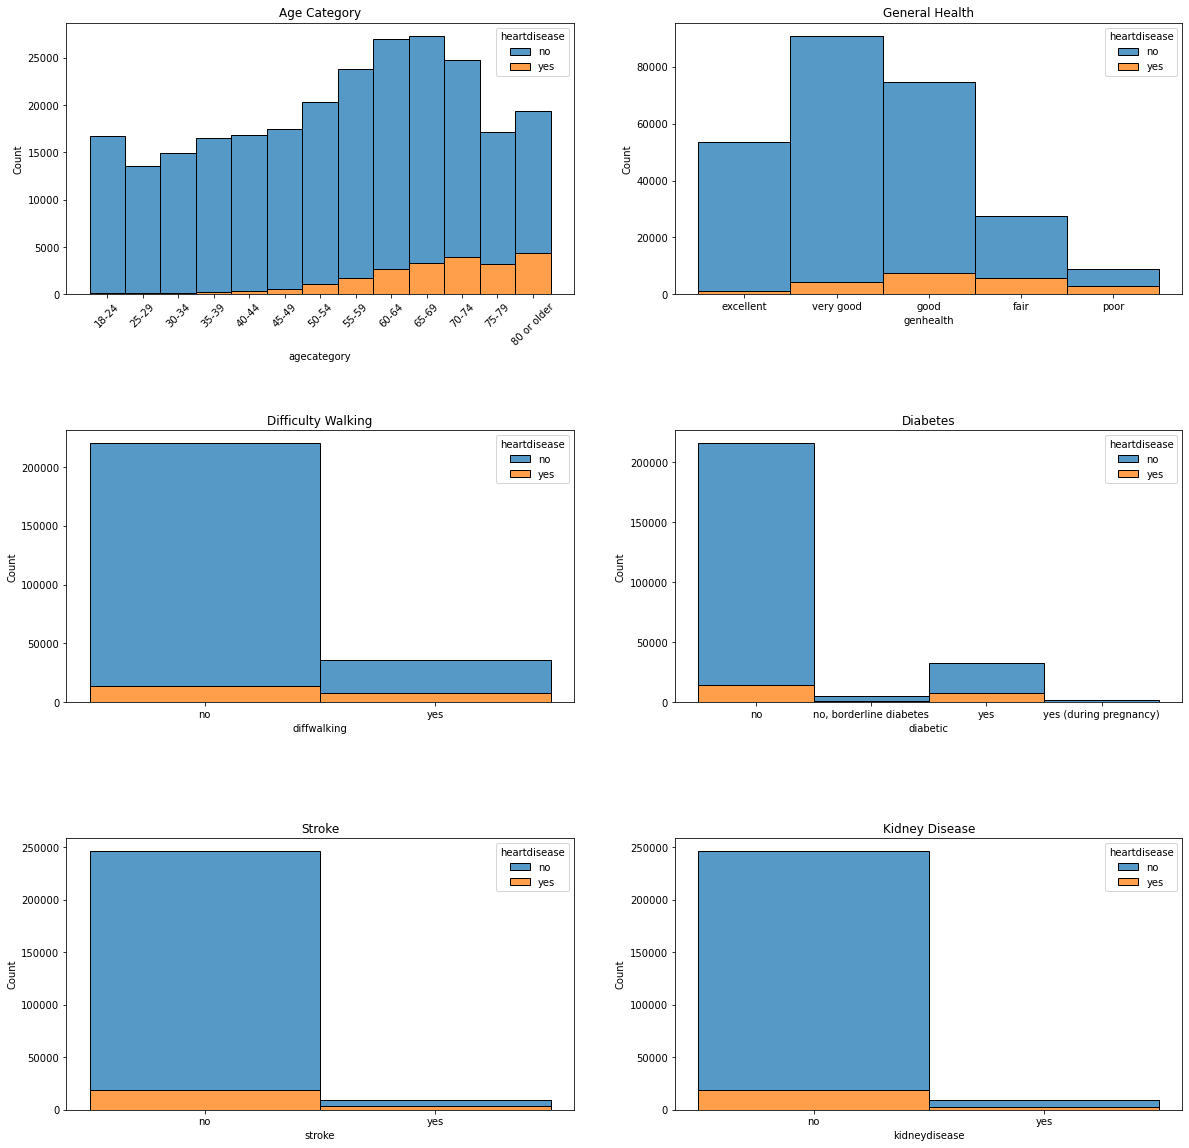

In [25]:
plt.rcParams["figure.figsize"] = (20,20)
fig, axes = plt.subplots(3, 2)
plt.subplots_adjust(hspace=0.5)

ax = sns.histplot(data=df_full_train.sort_values(by=top_categorical[0]), x=top_categorical[0], hue='heartdisease', 
                  multiple='stack', stat='count', ax=axes[0,0])
ax.set_xticklabels(labels=['18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
                           '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
                           '80 or older'], rotation=45)
ax.set_title('Age Category')


custom_dict = {'excellent':0, 'very good':1, 'good':2, 'fair':3, 'poor':4}
ax = sns.histplot(data=df_full_train.sort_values(by=[top_categorical[1]], key=lambda x: x.map(custom_dict)),
             x=top_categorical[1], hue='heartdisease', multiple='stack', stat='count', ax=axes[0,1])
ax.set_title('General Health')


ax = sns.histplot(data=df_full_train.sort_values(by=top_categorical[2]), x=top_categorical[2], hue='heartdisease', 
                  multiple='stack', stat='count', ax=axes[1,0])
ax.set_title('Difficulty Walking')

ax = sns.histplot(data=df_full_train.sort_values(by=top_categorical[3]), x=top_categorical[3], hue='heartdisease', 
                  multiple='stack', stat='count', ax=axes[1,1])
ax.set_title('Diabetes')

ax = sns.histplot(data=df_full_train.sort_values(by=top_categorical[4]), x=top_categorical[4], hue='heartdisease', 
                  multiple='stack', stat='count', ax=axes[2,0])
ax.set_title('Stroke')

ax = sns.histplot(data=df_full_train.sort_values(by=top_categorical[5]), x=top_categorical[5], hue='heartdisease', 
                  multiple='stack', stat='count', ax=axes[2,1])
ax.set_title('Kidney Disease')

plt.show()

The following plots show the proportion of people that have a heart disease based upon each feature of interest. With this plot it is much clearer, as it might be guessed, that as the age increases or some health issues arise the risk for a heart issue also increases.

In [26]:
heart_issues_categorical_dict = {}
for col in top_categorical:
    df_exploratory = df_full_train[[col, 'heartdisease']]
    df_exploratory['heartdisease'] = (df_exploratory['heartdisease']=='yes').astype('int')
    heart_issues_categorical_dict[col] = df_exploratory.groupby(col).sum()/df_exploratory.groupby(col).count()
    heart_issues_categorical_dict[col].reset_index(inplace=True)

/tmp/ipykernel_16635/3978846712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exploratory['heartdisease'] = (df_exploratory['heartdisease']=='yes').astype('int')


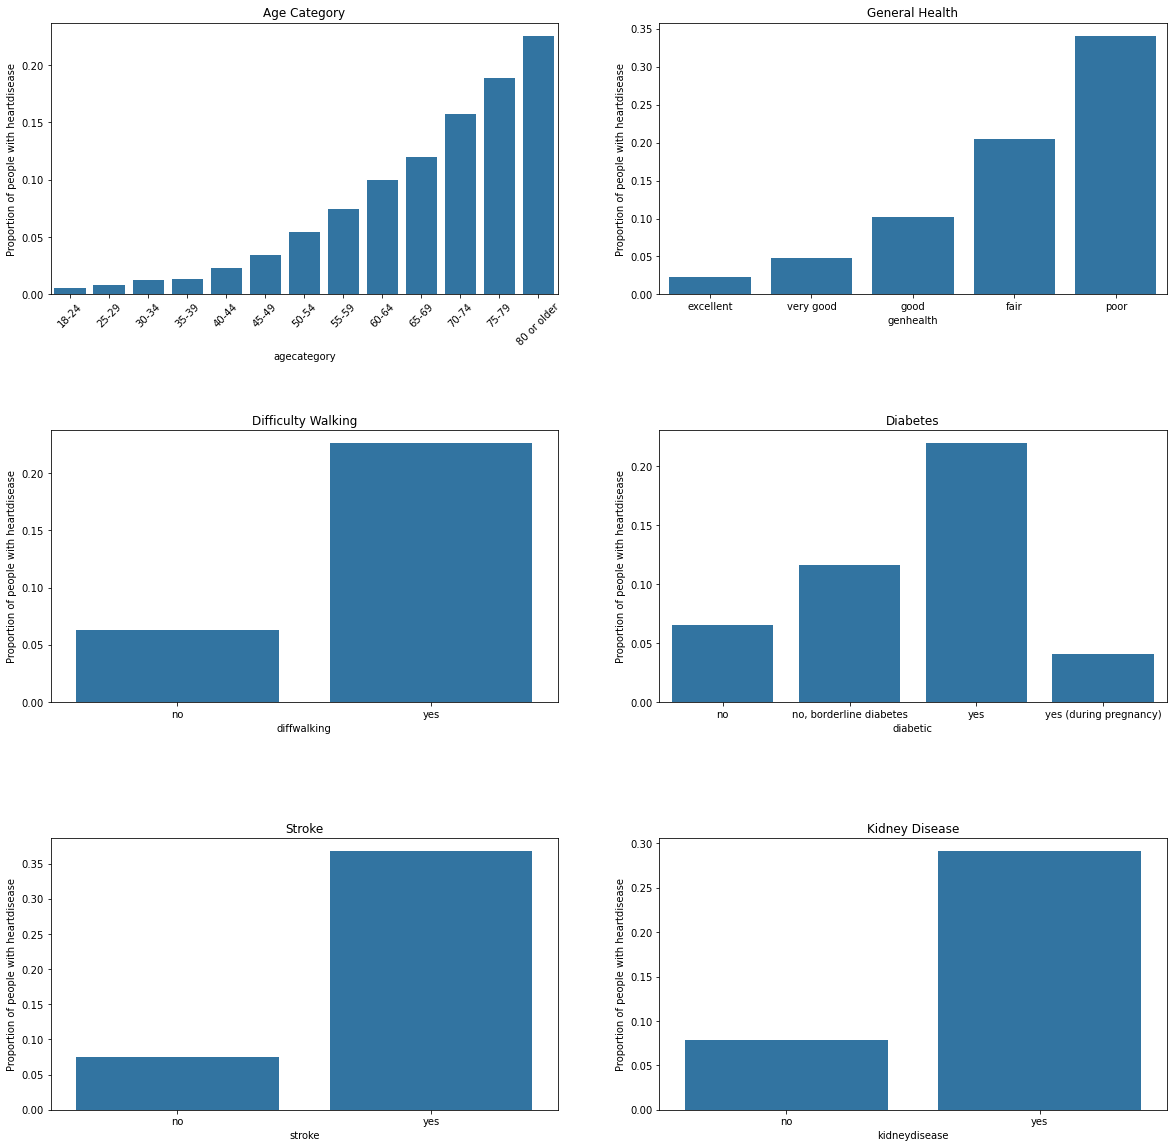

In [27]:
plt.rcParams["figure.figsize"] = (20,20)
fig, axes = plt.subplots(3, 2)
plt.subplots_adjust(hspace=0.5)

color = 'tab:blue'

ax = sns.barplot(data=heart_issues_categorical_dict[top_categorical[0]], 
                 y='heartdisease', x=top_categorical[0], ax=axes[0,0], color=color)
ax.set_ylabel('Proportion of people with heartdisease')
ax.set_xticklabels(labels=['18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
                           '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
                           '80 or older'], rotation=45)
ax.set_title('Age Category')

custom_dict = {'excellent':0, 'very good':1, 'good':2, 'fair':3, 'poor':4}
ax = sns.barplot(data=heart_issues_categorical_dict[top_categorical[1]].sort_values(by=[top_categorical[1]], key=lambda x: x.map(custom_dict)), 
                 y='heartdisease', x=top_categorical[1], ax=axes[0,1], color=color)
ax.set_ylabel('Proportion of people with heartdisease')
ax.set_title('General Health')


ax = sns.barplot(data=heart_issues_categorical_dict[top_categorical[2]], 
                 y='heartdisease', x=top_categorical[2], ax=axes[1,0], color=color)
ax.set_ylabel('Proportion of people with heartdisease')
ax.set_title('Difficulty Walking')

ax = sns.barplot(data=heart_issues_categorical_dict[top_categorical[3]], 
                 y='heartdisease', x=top_categorical[3], ax=axes[1,1], color=color)
ax.set_ylabel('Proportion of people with heartdisease')
ax.set_title('Diabetes')

ax = sns.barplot(data=heart_issues_categorical_dict[top_categorical[4]], 
                 y='heartdisease', x=top_categorical[4], ax=axes[2,0], color=color)
ax.set_ylabel('Proportion of people with heartdisease')
ax.set_title('Stroke')

ax = sns.barplot(data=heart_issues_categorical_dict[top_categorical[5]], 
                 y='heartdisease', x=top_categorical[5], ax=axes[2,1], color=color)
ax.set_ylabel('Proportion of people with heartdisease')
ax.set_title('Kidney Disease')


plt.show()

## 4.2 Numerical features
In the case of numerical features we found using correlation that two are of great interest.

In [28]:
top_numerical = ['physicalhealth', 'bmi']

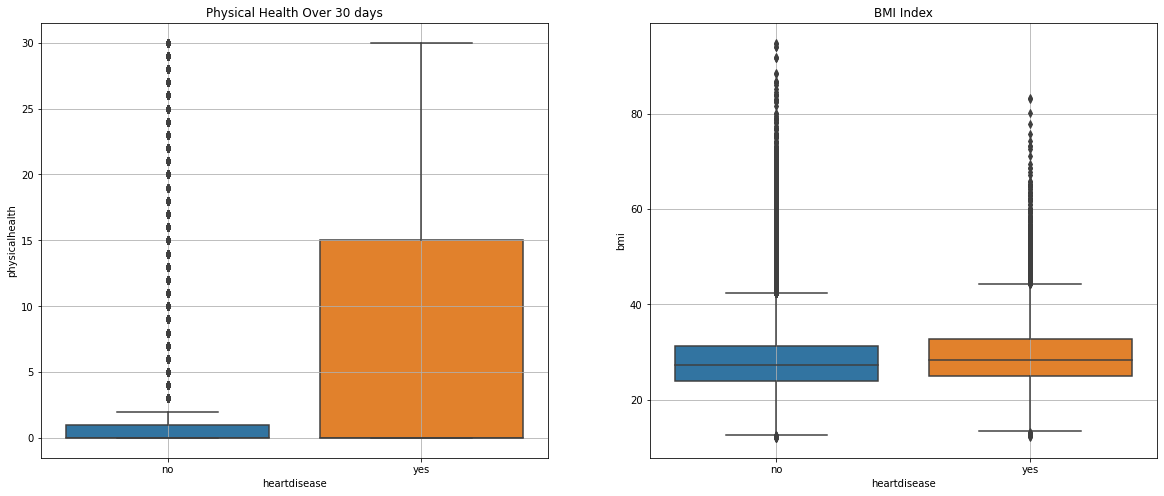

In [29]:
plt.rcParams["figure.figsize"] = (20,8)
fig, axes = plt.subplots(1, 2)
plt.subplots_adjust(hspace=0.5)

ax = sns.boxplot(data=df_full_train, y=top_numerical[0], x='heartdisease', ax=axes[0])
#ax = sns.violinplot(data=df_full_train, y=top_numerical[0], x='heartdisease', ax=axes[0])
ax.set_title('Physical Health Over 30 days')
ax.grid('on')

ax = sns.boxplot(data=df_full_train, y=top_numerical[1], x='heartdisease', ax=axes[1])
#ax = sns.violinplot(data=df_full_train, y=top_numerical[1], x='heartdisease', ax=axes[1])

ax.set_title('BMI Index')
ax.grid('on')

plt.show()

From these plots we could see some interesting remarks:
* People with heart diseases tend to describre longer periods of physical health discomfort.
* A period of health discomfort of two weeks might be an indicator of a possible heart problem.
* BMI index for people with or without heart disease is very similar but there is a silightly higher value for people with heartdiseases. (Below is a further discussion.)


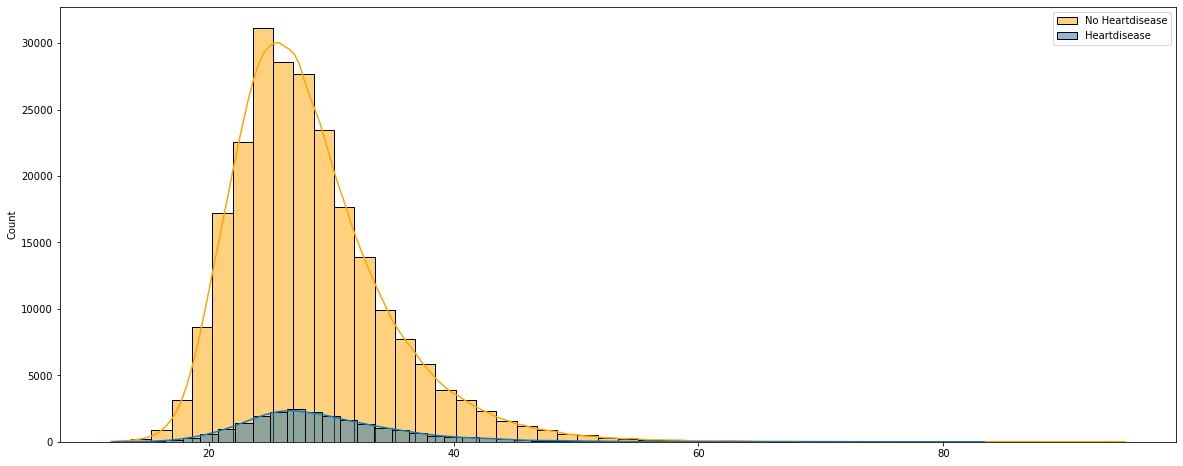

In [30]:
bins = 50

data_samples_yes = df_full_train[df_full_train['heartdisease']=='yes']['bmi'].values
data_samples_no = df_full_train[df_full_train['heartdisease']=='no']['bmi'].values
data_samples = df_full_train['bmi'].values

#sns.histplot(df_full_train['bmi'], color='red', bins=bins)
sns.histplot(data_samples_no, color='orange', bins=bins, label='No Heartdisease', kde=True)
sns.histplot(data_samples_yes, bins=bins, label='Heartdisease', kde=True)
plt.legend()
plt.show()

Null Hypothesis: The BMI mean of people with heart diseases is greater than the BMI mean of people without heart diseases. 

In [31]:
stats.ks_2samp(data_samples_yes, data_samples_no, alternative='greater')

KstestResult(statistic=0.0008436745818113569, pvalue=0.9712007424445028)

There is statistical significance $(p>0.05)$ to say that in fact the BMI mean of people with heart disease is greater than the BMI mean of the healthy group.

In [50]:
stat, p = stats.ks_2samp(data_samples_yes, data_samples_no, alternative='greater')
print('p value: %.3f'%p)

p value: 0.971


In [51]:
if p > 0.05:
    print('Probably greater mean for group with heart disease')
else:
    print('Probably same mean for group with heart disease')

Probably greater mean for group with heart disease
